# Blog Post: Newton's Method for Logistic Regression
## Introduction
First of all, here is a link to my LogisticRegression source code with NewtonOptimizer: https://github.com/ShadowedSpace/ShadowedSpace.github.io/blob/main/posts/BP8/LogisticRegression.py

Logistic regression was so fun I just had to try implementing it with another method! In this blog post, I will start by implementing Newton's Method, a second-order optimization technique that computes the second derivatives of the loss function. This primarily involves calculating the Hessian Matrix of second derivatives of the loss. Once I've done this, I will perform experiments to show that:
    1) Newton's Method does converge
    2) Newton's Method can converge faster than gradient descent
    3) Newton's Method fails to converge if alpha is too high
Finally, I will do an analysis of the time complexity of Newton's Method versus Gradient Descent.

In [93]:
%load_ext autoreload
%autoreload 2
from LogisticRegression import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt 
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# generates data for classification problem

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

X, y = classification_data(noise = 1)
w = torch.linspace(-1, 1, X.shape[1])

In [95]:
# plots data and boundary decision based on w
# only works for dimension = 2

def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data
    targets = [0, 1]
    markers = ["o", ","]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = colors[i], cmap = "BrBG", marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

In [96]:
# calculates the accuracy of a model

def accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum()
    total = y_true.shape[0]
    print(correct)
    return correct / total

In [97]:
LR = LogisticRegression(w)
opt = NewtonOptimizer(LR, w)

losses = []

for _ in range(100):
    losses.append(LR.loss(X, y))
    opt.step(X, y, alpha = 200)

### Experiment 1
This experiment will do two things. First, it will show that Newton's Method can converge. It will also show that Newton's method can converge faster than Gradient Descent with the proper parameters.

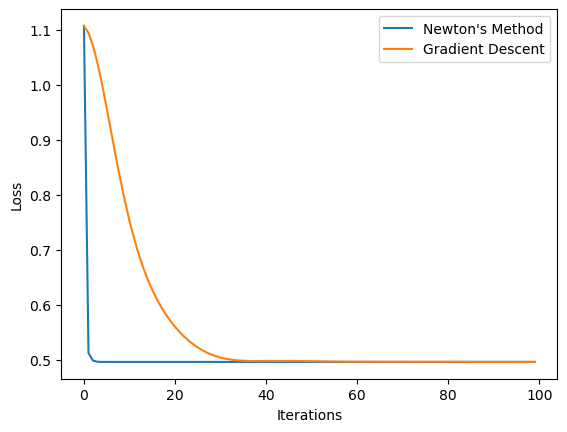

In [98]:
w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])

LR_grad = LogisticRegression(w)
opt = GradientDescentOptimizer(LR_grad, w, w_prev)

losses_grad = []

for _ in range(100):
    losses_grad.append(LR_grad.loss(X, y))
    opt.step(X, y, alpha = 0.05, beta = 0.9)

plt.plot(losses, label="Newton's Method")
plt.plot(losses_grad, label = "Gradient Descent")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

Awesome! As we can see here, the blue plot of the losses of Newton's Method converges practically instantly - definitely much faster than the orange losses of Gradient Descent with Momentum.  

### Experiment 2
Here, I'm aiming to show that Newton's Method converging is contingent on a suitably small alpha.

In [101]:
LR_broken = LogisticRegression(w)
opt = NewtonOptimizer(LR_broken, w)

losses = []

for _ in range(6):
    losses.append(LR_broken.loss(X, y))
    opt.step(X, y, alpha = 341)

Text(0, 0.5, 'Loss')

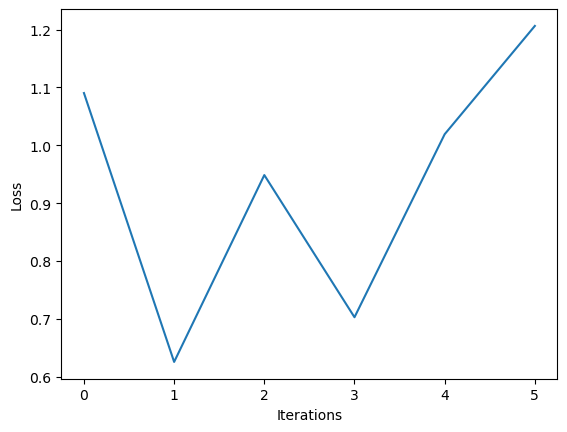

In [ ]:
plt.plot(losses, label="Newton's Method")
plt.xlabel("Iterations")
plt.ylabel("Loss")

And... that doesn't look so great. Fortunately, in this case, not so great is exactly what we were hoping for. This plot of oscillating losses shows that Newton's Method can fail to converge if the value of alpha is too high.

### Time Complexity Analysis
Let p be the number of features, and let the cost of computing the loss be c computational units, the gradient be 2c computational units, the hessian be pc computational units. Suppose also that it costs $k_1p^\gamma$ to invert a $pxp$ matrix, and $k_2p^2$ to do the matrix-vector multiplication required by Newton's Method.

Computational cost of Gradient Descent:
    - computing the loss, (c computational units)
    - computing the gradient (2c computational units)
    - multiply by the number of steps for convergence, $t_{gd}$

$$
T(GradientDescent) = O(t_{gd} 3c)
$$

Computational cost of Newton's Method: 
    - everything required by gradient descent
    - computing the hessian (pc computational units)
    - inverting a $pxp$ matrix ($k_1p^\gamma$ computational units)
    - matrix-vector operation ($k_2p^2$)

$$
T(NewtonOptimizer) = O(t_{nm} (c(3 + p) + k_1p^\gamma + k_2p^2))
$$  

So... $t_{gd}$ needs to be a lot smaller than $t_{nm}$ for Newton's Method to be worthwhile. As p increases, the $k_1p^\gamma$ and $k_2p^2$ terms will grow overwhelmingly, so the fast convergence likely isn't worth it for large values of p.

## Conclusion
Another cool blog post! I really liked how this one built off of the Logistic Regression blog post, and I think it boosted my understanding of both (probably through the excruciatingly frustrating debugging process). The practice with vectorized operations was helpful, and I enjoyed the comparison between the two methods of Logistic Regression (both in terms of seeing Newton's Method converge faster in Experiment 1, and then looking at the limited cases in which this actually happens via the time complexity analysis).